Ejercicio:
Una institución ambiental desea desarrollar una herramienta que le permita identificar regiones con alta probabilidad de tener incendios forestales.

Usando una red neuronal, debe crear un modelo de Machine Learning con el fin de poder resolver el problema. Es de libre elección el tipo de red neuronal y el conjunto de datos a usar. En el preprocesamiento de los datos debe aplicar un algoritmo de cluster ya sea para seleccionar las características o para encontrar patrones en los datos.

In [1]:
# Librerías básicas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.pipeline import Pipeline

# Cargamos el dataset
df = pd.read_csv('CANADA_WILDFIRES.csv')
df.shape

(423831, 9)

In [2]:
# Vistazo inicial: primeras filas, tipos y valores faltantes
display(df.head())
print('--- Información de columnas ---')
print(df.info())
print('--- Descripción numérica ---')
display(df.describe(include='all'))

,FID,SRC_AGENCY,LATITUDE,LONGITUDE,REP_DATE,SIZE_HA,CAUSE,PROTZONE,ECOZ_NAME
0,0,BC,59.963,-128.172,1953-05-26,8.0,H,,Boreal Cordillera
1,1,BC,59.318,-132.172,1950-06-22,8.0,L,,Boreal Cordillera
2,2,BC,59.876,-131.922,1950-06-04,12949.9,H,,Boreal Cordillera
3,3,BC,59.760,-132.808,1951-07-15,241.1,H,,Boreal Cordillera
4,4,BC,59.434,-126.172,1952-06-12,1.2,H,,Boreal Cordillera


--- Información de columnas ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423831 entries, 0 to 423830
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   FID         423831 non-null  int64  
 1   SRC_AGENCY  423831 non-null  object 
 2   LATITUDE    423831 non-null  float64
 3   LONGITUDE   423831 non-null  float64
 4   REP_DATE    420118 non-null  object 
 5   SIZE_HA     423831 non-null  float64
 6   CAUSE       423590 non-null  object 
 7   PROTZONE    422821 non-null  object 
 8   ECOZ_NAME   423831 non-null  object 
dtypes: float64(3), int64(1), object(5)
memory usage: 29.1+ MB
None
--- Descripción numérica ---


,FID,SRC_AGENCY,LATITUDE,LONGITUDE,REP_DATE,SIZE_HA,CAUSE,PROTZONE,ECOZ_NAME
count,423831.000000,423831,423831.000000,423831.000000,420118,4.238310e+05,423590,422821,423831
unique,NaN,56,NaN,NaN,17664,NaN,5,40,17
top,NaN,BC,NaN,NaN,1994-08-03,NaN,H,,Montane Cordillera
freq,NaN,149410,NaN,NaN,736,NaN,230498,333463,120880
mean,211915.000000,NaN,51.895936,-104.253547,NaN,3.162710e+02,NaN,NaN,NaN
std,122349.615308,NaN,4.467770,20.412661,NaN,5.617050e+03,NaN,NaN,NaN
min,0.000000,NaN,0.000000,-166.044000,NaN,0.000000e+00,NaN,NaN,NaN
25%,105957.500000,NaN,49.133700,-120.112350,NaN,1.000000e-01,NaN,NaN,NaN
50%,211915.000000,NaN,51.023000,-114.503000,NaN,1.000000e-01,NaN,NaN,NaN
75%,317872.500000,NaN,54.630289,-88.303603,NaN,1.000000e+00,NaN,NaN,NaN


In [3]:
# Analizamos valores únicos en variables categóricas relevantes
print('SRC_AGENCY unique:', df['SRC_AGENCY'].nunique())
print(df['SRC_AGENCY'].value_counts().head())
print('CAUSE unique:', df['CAUSE'].unique())
print('ECOZ_NAME unique:', df['ECOZ_NAME'].nunique())
print(df['ECOZ_NAME'].value_counts().head())

SRC_AGENCY unique: 56
SRC_AGENCY
BC    149410
ON     63508
AB     62707
QC     43124
MB     27508
Name: count, dtype: int64
CAUSE unique: ['H' 'L' 'U' 'RE' 'H-PB' nan]
ECOZ_NAME unique: 17
ECOZ_NAME
Montane Cordillera    120880
Boreal PLain           78544
Boreal Shield East     68168
Boreal Shield West     58847
Atlantic Maritime      25981
Name: count, dtype: int64


In [4]:
# Convertimos la fecha y extraemos año/mes/día para análisis temporal
df['REP_DATE'] = pd.to_datetime(df['REP_DATE'], errors='coerce')
df['year'] = df['REP_DATE'].dt.year
df['month'] = df['REP_DATE'].dt.month
df['day'] = df['REP_DATE'].dt.day
display(df[['REP_DATE','year','month','day']].head())

,REP_DATE,year,month,day
0,1953-05-26,1953.0,5.0,26.0
1,1950-06-22,1950.0,6.0,22.0
2,1950-06-04,1950.0,6.0,4.0
3,1951-07-15,1951.0,7.0,15.0
4,1952-06-12,1952.0,6.0,12.0


## Análisis exploratorio (visualizaciones)
A continuación se muestran histogramas, boxplots y mapa de correlación para entender la distribución y relaciones entre variables numéricas.

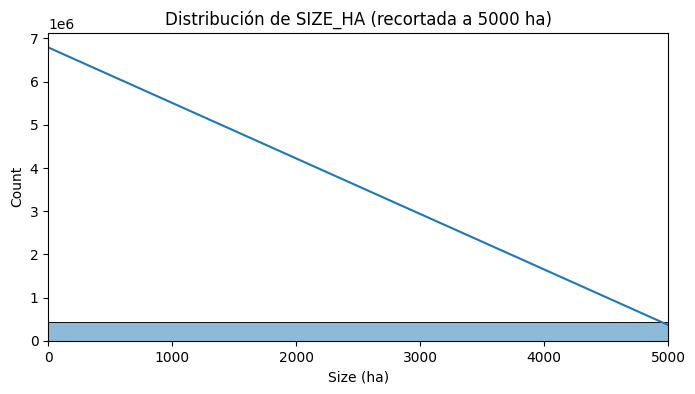

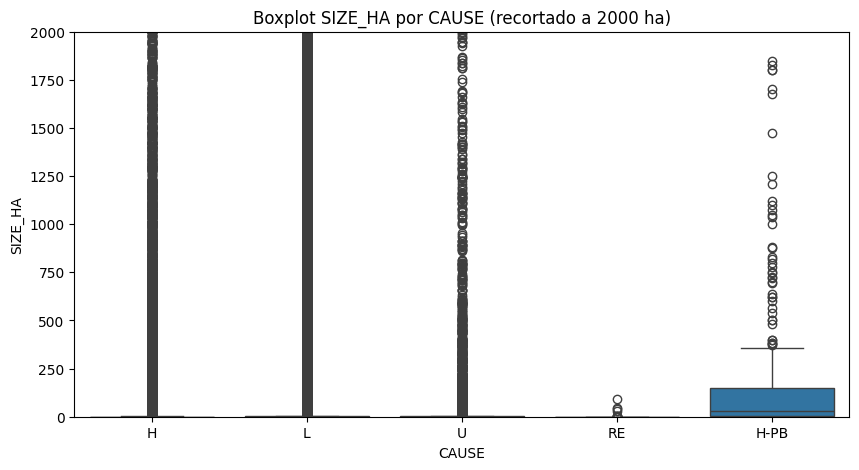

In [5]:
# Histograma del tamaño del incendio (SIZE_HA)
plt.figure(figsize=(8,4))
sns.histplot(df['SIZE_HA'].replace([np.inf, -np.inf], np.nan).dropna(), bins=60, kde=True)
plt.xlim(0, 5000)  # límite para visualizar la mayor parte de la distribución; ajustar según necesidad
plt.title('Distribución de SIZE_HA (recortada a 5000 ha)')
plt.xlabel('Size (ha)')
plt.show()

# Boxplot: tamaño vs causa
plt.figure(figsize=(10,5))
sns.boxplot(x='CAUSE', y='SIZE_HA', data=df.replace({'CAUSE':{' ':np.nan}}))
plt.ylim(0, 2000)
plt.title('Boxplot SIZE_HA por CAUSE (recortado a 2000 ha)')
plt.show()

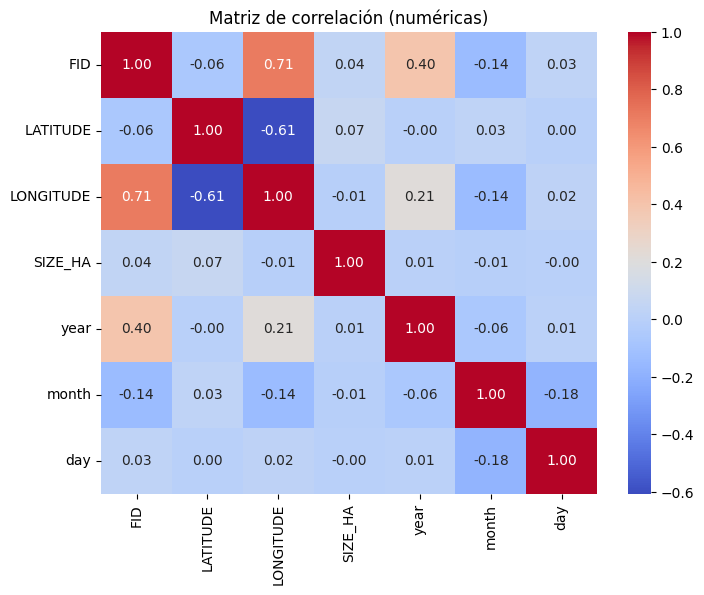

In [6]:
# Heatmap de correlación para variables numéricas
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
plt.figure(figsize=(8,6))
corr = df[num_cols].corr()
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Matriz de correlación (numéricas)')
plt.show()

## Identificación de datos faltantes y limpieza (bloque de código)
El siguiente bloque muestra los valores faltantes y decisiones de limpieza: eliminar columnas irrelevantes o con demasiados vacíos, y crear una variable objetivo.

In [7]:
# Valores faltantes por columna (conteo y porcentaje)
miss = df.isnull().sum().sort_values(ascending=False)
miss_pct = (df.isnull().mean()*100).sort_values(ascending=False)
missing = pd.concat([miss, miss_pct], axis=1, keys=['count','percent'])
display(missing.head(20))

# Observamos PROTZONE que en muchas filas aparece como espacio o vacío -> lo limpiamos
df['PROTZONE'] = df['PROTZONE'].replace(' ', np.nan).replace('', np.nan)
display(df['PROTZONE'].value_counts(dropna=False).head())

# Decisiones de limpieza:
# - Eliminamos 'FID' porque es un identificador sin información predictiva
# - Eliminamos 'PROTZONE' si tiene demasiados vacíos (en este dataset aparece vacío la mayoría)
# - Convertimos categorías vacías a 'Unknown' donde aplique

if 'FID' in df.columns:
    df = df.drop(columns=['FID'])
# Drop PROTZONE si >70% missing (condición automática)
if df['PROTZONE'].isnull().mean() > 0.7:
    df = df.drop(columns=['PROTZONE'])

# Rellenamos CAUSE vacías con 'Unknown' y SRC_AGENCY similarmente
df['CAUSE'] = df['CAUSE'].replace(' ', np.nan).fillna('Unknown')
df['SRC_AGENCY'] = df['SRC_AGENCY'].fillna('Unknown')

# Eliminamos filas con REP_DATE inválida (si las hay)
df = df[~df['REP_DATE'].isnull()]
df.shape

,count,percent
year,3713,0.876057
month,3713,0.876057
day,3713,0.876057
REP_DATE,3713,0.876057
PROTZONE,1010,0.238303
CAUSE,241,0.056862
SRC_AGENCY,0,0.000000
FID,0,0.000000
LONGITUDE,0,0.000000
LATITUDE,0,0.000000


PROTZONE
NaN               334473
Intensive          62725
EXT                 4242
Initial Attack      3158
Monitored           3117
Name: count, dtype: int64

(420118, 10)

## Feature engineering y clustering con KMeans
Usaremos clustering espacial (LATITUDE, LONGITUDE) para encontrar regiones/patrones y usar el cluster como característica.

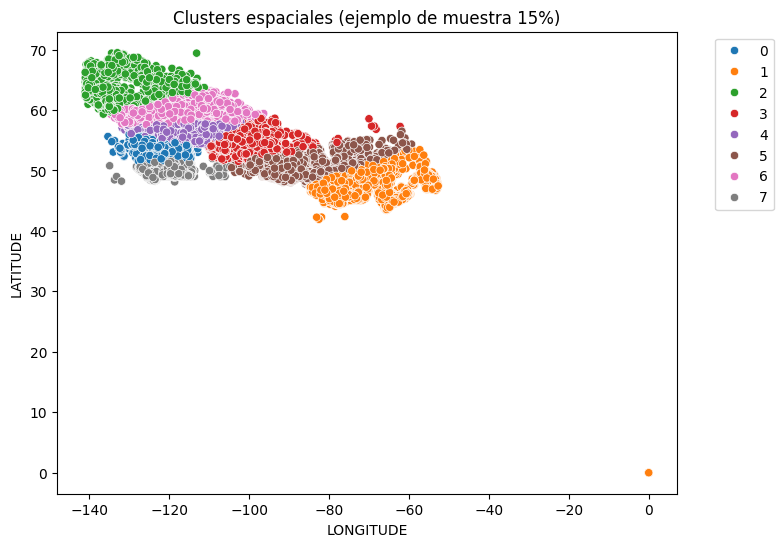

In [8]:
# Aplicamos KMeans sobre LAT/LON (normalizamos antes)
coords = df[['LATITUDE','LONGITUDE']].dropna()
scaler_coords = StandardScaler()
coords_scaled = scaler_coords.fit_transform(coords)
km = KMeans(n_clusters=8, random_state=42)
cluster_labels = km.fit_predict(coords_scaled)
# Alineamos labels con el índice original
df.loc[coords.index, 'cluster'] = cluster_labels
df['cluster'] = df['cluster'].astype(int)

# Visualizamos clusters sobre coordenadas
plt.figure(figsize=(8,6))
sns.scatterplot(x='LONGITUDE', y='LATITUDE', hue='cluster', palette='tab10', data=df.sample(frac=0.15, random_state=1))
plt.title('Clusters espaciales (ejemplo de muestra 15%)')
plt.legend(bbox_to_anchor=(1.05,1), loc=2)
plt.show()

## Creación de variable objetivo (target) para clasificación:
Planteo: predecir si un incendio será 'grande' (por ejemplo > mediana del dataset). Para balancear clases usamos la mediana de SIZE_HA como umbral. Esto convierte el problema en clasificación binaria y permite evaluar una red neuronal.

In [9]:
# Definimos target 'large_fire' usando la mediana para balance razonable
threshold = df['SIZE_HA'].median()
print('Umbral (mediana) SIZE_HA =', threshold)
df['large_fire'] = (df['SIZE_HA'] >= threshold).astype(int)
print('Distribución de la clase target:')
print(df['large_fire'].value_counts(normalize=True))

Umbral (mediana) SIZE_HA = 0.10000000149
Distribución de la clase target:
large_fire
1    0.543814
0    0.456186
Name: proportion, dtype: float64


## Preparación de datos para el modelo y entrenamiento de red neuronal (MLP)
Usaremos variables numéricas y codificaremos las categóricas con get_dummies; incluimos el cluster obtenido como característica.

In [10]:
# Selección de features candidatas
features = ['LATITUDE','LONGITUDE','month','year','cluster','SRC_AGENCY','CAUSE','ECOZ_NAME']
# Algunas columnas pueden faltar en casos raros; quedarnos con las que existan
features = [f for f in features if f in df.columns]
X = df[features].copy()
y = df['large_fire'].copy()

# Codificamos categóricas con get_dummies (sencillo y reproducible)
X = pd.get_dummies(X, columns=[c for c in X.columns if X[c].dtype == 'object' or str(c)=='cluster'], drop_first=True)

# Rellenamos NA numéricos con la mediana (si existe alguno)
for col in X.select_dtypes(include=[np.number]).columns:
    X[col] = X[col].fillna(X[col].median())

# División entrenamiento/prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Estandarizamos características numéricas
scaler = StandardScaler()
num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

print('Dimensiones X_train, X_test: ', X_train.shape, X_test.shape)
print('Balance y_train:')
print(y_train.value_counts(normalize=True))

Dimensiones X_train, X_test:  (336094, 87) (84024, 87)
Balance y_train:
large_fire
1    0.543815
0    0.456185
Name: proportion, dtype: float64


In [12]:
# Entrenamiento de una red neuronal MLP con Keras
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

input_dim = X_train.shape[1]
model = Sequential([
    Dense(128, activation='relu', input_shape=(input_dim,)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=64, callbacks=[es], verbose=2)

# Evaluación
preds = (model.predict(X_test) > 0.5).astype(int).ravel()
acc = accuracy_score(y_test, preds)
print('Accuracy en test:', acc)
print(classification_report(y_test, preds))
print('Confusion matrix:')
print(confusion_matrix(y_test, preds))
print('ROC AUC (si aplica):', roc_auc_score(y_test, model.predict(X_test)))

c:\Users\administrator\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │        11,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,585 (76.50 KB)

 Trainable params: 19,585 (76.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
4202/4202 - 10s - 2ms/step - accuracy: 0.7274 - loss: 0.5194 - val_accuracy: 0.7363 - val_loss: 0.5036
Epoch 2/100
4202/4202 - 10s - 2ms/step - accuracy: 0.7274 - loss: 0.5194 - val_accuracy: 0.7363 - val_loss: 0.5036
Epoch 2/100
4202/4202 - 5s - 1ms/step - accuracy: 0.7359 - loss: 0.5067 - val_accuracy: 0.7390 - val_loss: 0.5009
Epoch 3/100
4202/4202 - 5s - 1ms/step - accuracy: 0.7359 - loss: 0.5067 - val_accuracy: 0.7390 - val_loss: 0.5009
Epoch 3/100
4202/4202 - 5s - 1ms/step - accuracy: 0.7379 - loss: 0.5040 - val_accuracy: 0.7408 - val_loss: 0.5004
Epoch 4/100
4202/4202 - 5s - 1ms/step - accuracy: 0.7379 - loss: 0.5040 - val_accuracy: 0.7408 - val_loss: 0.5004
Epoch 4/100
4202/4202 - 5s - 1ms/step - accuracy: 0.7389 - loss: 0.5022 - val_accuracy: 0.7421 - val_loss: 0.4991
Epoch 5/100
4202/4202 - 5s - 1ms/step - accuracy: 0.7389 - loss: 0.5022 - val_accuracy: 0.7421 - val_loss: 0.4991
Epoch 5/100
4202/4202 - 5s - 1ms/step - accuracy: 0.7401 - loss: 0.5013 - val_accuracy

## Observaciones y justificación final
Al ejecutar el notebook se deben revisar los outputs intermedios: distribución de la variable objetivo, balance de clases y métricas del modelo.
- Si la exactitud (accuracy) no alcanza 0.80 se proponen los siguientes pasos: ajustar threshold de 'large_fire' (por ejemplo usar percentil 75 en vez de mediana), hacer ingeniería de features adicionales (p. ej. densidad de incendios por cluster en ventanas temporales), ajustar arquitectura de la red o balancear clases (oversampling/undersampling).
- El uso de KMeans aportó una característica espacial ('cluster') que ayuda al modelo a capturar regiones con historial de incendios.
- En la sección de limpieza se justificó eliminar 'FID' y 'PROTZONE' por ser no informativas o contener muchos vacíos.
- Con los resultados se debe comparar la distribución real de incendios (maps/cluster) con las predicciones para validar zonas de riesgo detectadas.